# Task 2. Задание 2

You need to build a model that, based on the data received every minute, determines the quality of the products produced by the roasting machine.

The roasting machine is an aggregate consisting of 5 chambers of the same size, 3 temperature sensors are installed in each chamber. In addition, for this task, you have collected data on the height of the raw material layer and its humidity. The layer height and humidity are measured when the raw material enters the machine. The raw material passes through the roasting machine in an hour.

The quality of products is measured in the laboratory by samples that are taken every hour, data on known analyses are contained in the file `Y_train.csv`. The file indicates the time of sampling, the sample is taken at the exit of the firing machine.
You have agreed with the customer that the evaluation of the model will be the indicator `MAE`, to evaluate the model, you need to generate predictions for the period specified in the file `Y_submit.csv` (5808 predicts).

Вам необходимо построить модель, которая на основании данных, поступающих каждую минуту, определяют качество продукции, производимое на обжиговой машине.

Обжиговая машина представляет собой агрегат, состоящий из 5 одинаковых по размеру камер, в каждой камере установлено по 3 датчика температур. Кроме этого, для данной задачи Вы собрали данные о высоте слоя сырья и его влажности. Высота слоя и влажность измеряются при входе сырья в машину. Сырье проходит через обжиговую машину за час.

Качество продукции измеряется в лаборатории по пробам, которые забираются каждый час, данные по известным анализам содержатся в файле `Y_train.csv`. В файле указано время забора пробы, проба забирается на выходе из обжиговой машины.
Вы договорились с заказчиком, что оценкой модели будет являться показатель `MAE`, для оценки модели необходимо сгенерировать предсказания за период, указанный в файле `Y_submit.csv` (5808 предиктов).

## Libs import. Импорт библиотек

In [1]:
import pandas as pd
from IPython.display import display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from scipy import stats as st
from joblib import Parallel, delayed
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from vecstack import stacking

### Installing stacking lib. Установка библиотеки стэкинга

In [2]:
#pip install vecstack

Cells scrolling is off. Вспомогательный модуль для устранения скроллинга ячеек

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Data loading and EDA. Загрузка и изучение файлов

### `X_data`

In [4]:
X_data = pd.read_csv('F:/Северсталь/Task2/X_data.csv', encoding='cp1251', sep=';')
X_data.rename(columns = {"Unnamed: 0": "date"}, inplace = True)
X_data['date'] = pd.to_datetime(X_data['date'], format = '%Y-%m-%d %H:%M:%S')+pd.Timedelta(hours = 1)
print('Количество строк-дубликатов:', X_data.duplicated().sum())
X_data.index = X_data['date']
X_data = X_data.drop(['date'], axis = 1)
display(X_data.head(3))
print('')
display(X_data.info(null_counts = True))
print('')
display(X_data.describe())

Количество строк-дубликатов: 0


,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
date,,,,,,,,,,,,,,,,,
2015-01-01 01:00:00,212,210,211,347,353,347,474,473,481,346,348,355,241,241,243,167.85,9.22
2015-01-01 01:01:00,212,211,211,346,352,346,475,473,481,349,348,355,241,241,243,162.51,9.22
2015-01-01 01:02:00,212,211,211,345,352,346,476,473,481,352,349,355,242,241,242,164.99,9.22



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2103841 entries, 2015-01-01 01:00:00 to 2019-01-01 01:00:00
Data columns (total 17 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   T_data_1_1  2103841 non-null  int64  
 1   T_data_1_2  2103841 non-null  int64  
 2   T_data_1_3  2103841 non-null  int64  
 3   T_data_2_1  2103841 non-null  int64  
 4   T_data_2_2  2103841 non-null  int64  
 5   T_data_2_3  2103841 non-null  int64  
 6   T_data_3_1  2103841 non-null  int64  
 7   T_data_3_2  2103841 non-null  int64  
 8   T_data_3_3  2103841 non-null  int64  
 9   T_data_4_1  2103841 non-null  int64  
 10  T_data_4_2  2103841 non-null  int64  
 11  T_data_4_3  2103841 non-null  int64  
 12  T_data_5_1  2103841 non-null  int64  
 13  T_data_5_2  2103841 non-null  int64  
 14  T_data_5_3  2103841 non-null  int64  
 15  H_data      2103841 non-null  float64
 16  AH_data     2103841 non-null  float64
dtypes: float64(2), int64(15)
memory

None

,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
count,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06
mean,2.501822e+02,2.500915e+02,2.502536e+02,3.497756e+02,3.497218e+02,3.498282e+02,5.011611e+02,5.011092e+02,5.012335e+02,3.493196e+02,3.494390e+02,3.500299e+02,2.497488e+02,2.496311e+02,2.496937e+02,1.747170e+02,7.499369e+00
std,3.211661e+01,3.082451e+01,3.069125e+01,4.225961e+01,4.067887e+01,3.798444e+01,6.325732e+01,6.337164e+01,6.223294e+01,3.930562e+01,3.919989e+01,4.018360e+01,3.073298e+01,3.050021e+01,3.074629e+01,1.443613e+01,1.148026e+00
min,-1.980000e+02,-1.220000e+02,-1.070000e+02,-7.030000e+02,-9.580000e+02,-1.910000e+02,-7.750000e+02,-7.590000e+02,-6.130000e+02,-5.140000e+02,-4.710000e+02,-6.090000e+02,-8.900000e+01,-1.250000e+02,-1.630000e+02,1.414900e+02,2.890000e+00
25%,2.290000e+02,2.290000e+02,2.290000e+02,3.280000e+02,3.280000e+02,3.280000e+02,4.640000e+02,4.640000e+02,4.640000e+02,3.270000e+02,3.280000e+02,3.280000e+02,2.290000e+02,2.290000e+02,2.290000e+02,1.624400e+02,6.730000e+00
50%,2.500000e+02,2.500000e+02,2.500000e+02,3.500000e+02,3.500000e+02,3.500000e+02,5.020000e+02,5.020000e+02,5.020000e+02,3.490000e+02,3.500000e+02,3.500000e+02,2.490000e+02,2.500000e+02,2.500000e+02,1.744000e+02,7.510000e+00
75%,2.720000e+02,2.720000e+02,2.720000e+02,3.720000e+02,3.720000e+02,3.720000e+02,5.380000e+02,5.380000e+02,5.390000e+02,3.720000e+02,3.720000e+02,3.720000e+02,2.700000e+02,2.710000e+02,2.710000e+02,1.870100e+02,8.270000e+00
max,7.240000e+02,7.620000e+02,6.650000e+02,1.302000e+03,1.179000e+03,8.890000e+02,1.587000e+03,2.505000e+03,1.319000e+03,1.177000e+03,1.244000e+03,9.440000e+02,9.050000e+02,7.380000e+02,6.240000e+02,2.078300e+02,1.184000e+01


X_data data has been loaded.

- The column `Unnamed: 0` was renamed to `date`, converted to the `datetime` type and set by the index.
- To synchronize the start time of firing (when measuring the humidity and thickness of the sheet) and the sampling time at the exit of the machine, add 1 hour to the time counts (the time of passage of raw materials through the machine).
- No repetitions or omissions were detected.
- There are very low and high temperature values, they will be investigated and corrected below.

Выполненена загрузка данных X_data.

- Столбец `Unnamed: 0` переименован в `date`, преобразован к типу `datetime` и установлен индексом.
- Для синхронизации времени начала обжига (когда выполняется замер влажности и толщины листа) и времени забора проб на выходе из машины прибавляем 1 час к временным отсчетам (время прохода сырья через машину).
- Повторов и пропусков не обнаружено.
- Есть очень низкие и высокие значения температур, они будут исследованы и исправлены ниже.

### `Y_train`

In [5]:
def data_prep(Y):
    Y.rename(columns = {0: 'date', 1: 'quality'}, inplace = True)
    print('Количество строк-дубликатов:', Y.duplicated().sum())
    Y['date'] = pd.to_datetime(Y['date'], format = '%Y-%m-%d %H:%M:%S')
    Y.index = Y['date']
    Y = Y.drop(['date'], axis = 1)
    print('')
    display(Y.head(3))
    print('')
    print(Y.info(null_counts = True))
    print('')
    display(Y.describe())
    return Y

In [6]:
Y_train = pd.read_csv('F:/Metallurgy/Task2/Y_train.csv', encoding = 'cp1251', sep = ';', header = None)
Y_train = data_prep(Y_train)

Количество строк-дубликатов: 0



,quality
date,
2015-01-04 00:05:00,392
2015-01-04 01:05:00,384
2015-01-04 02:05:00,393



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29184 entries, 2015-01-04 00:05:00 to 2018-05-03 23:05:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   quality  29184 non-null  int64
dtypes: int64(1)
memory usage: 456.0 KB
None



,quality
count,29184.000000
mean,402.800747
std,46.273228
min,221.000000
25%,372.000000
50%,408.000000
75%,439.000000
max,505.000000


The target attribute of the training set has been loaded.

- The column `Unnamed: 0` was renamed to 'date`, converted to the `datetime` type and set by the index.
- No repetitions or omissions were detected.

Выполнена загрузка целевого признака обучающего множества.

- Столбец `Unnamed: 0` переименован в `date`, преобразован к типу `datetime` и установлен индексом.
- Повторов и пропусков не обнаружено.

### `Y_submit`

In [7]:
Y_submit = pd.read_csv('F:/Северсталь/Task2/Y_submit.csv', encoding = 'cp1251', sep = ';', header = None)
Y_submit = data_prep(Y_submit)

Количество строк-дубликатов: 0



,quality
date,
2018-05-04 00:05:00,420
2018-05-04 01:05:00,420
2018-05-04 02:05:00,420



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5808 entries, 2018-05-04 00:05:00 to 2018-12-31 23:05:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   quality  5808 non-null   int64
dtypes: int64(1)
memory usage: 90.8 KB
None



,quality
count,5808.0
mean,420.0
std,0.0
min,420.0
25%,420.0
50%,420.0
75%,420.0
max,420.0


The target attribute of the training set has been loaded.

- The column `Unnamed: 0` was renamed to `date`, converted to the `datetime` type and set by the index.

The target values will be replaced with those predicted by the model.

Выполнена загрузка целевого признака обучающего множества.

- Столбец `Unnamed: 0` переименован в `date`, преобразован к типу `datetime` и установлен индексом.

Целевые значения будут заменены на предсказанные моделью.

In this section, the loading and initial investigation of the data is performed. The synchronization of the data received at the entrance to the roasting machine and at the exit from it (after 1 hour) is also performed. Negative temperature values are present in the `X_data` array, they will be investigated and corrected below.

В данном разделе выполнена загрузка и первичное исследование данных. Так же выполнена синхронизация данных, которые получены на входе в обжиговую машину и на выходе из неё (через 1 час). В массиве `X_data` присутствуют отрицательные значения температур, они будут исследованы и исправлены ниже.

## Array `X_data`. Массив `X_data`

In [8]:
display(X_data.describe())

,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
count,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06
mean,2.501822e+02,2.500915e+02,2.502536e+02,3.497756e+02,3.497218e+02,3.498282e+02,5.011611e+02,5.011092e+02,5.012335e+02,3.493196e+02,3.494390e+02,3.500299e+02,2.497488e+02,2.496311e+02,2.496937e+02,1.747170e+02,7.499369e+00
std,3.211661e+01,3.082451e+01,3.069125e+01,4.225961e+01,4.067887e+01,3.798444e+01,6.325732e+01,6.337164e+01,6.223294e+01,3.930562e+01,3.919989e+01,4.018360e+01,3.073298e+01,3.050021e+01,3.074629e+01,1.443613e+01,1.148026e+00
min,-1.980000e+02,-1.220000e+02,-1.070000e+02,-7.030000e+02,-9.580000e+02,-1.910000e+02,-7.750000e+02,-7.590000e+02,-6.130000e+02,-5.140000e+02,-4.710000e+02,-6.090000e+02,-8.900000e+01,-1.250000e+02,-1.630000e+02,1.414900e+02,2.890000e+00
25%,2.290000e+02,2.290000e+02,2.290000e+02,3.280000e+02,3.280000e+02,3.280000e+02,4.640000e+02,4.640000e+02,4.640000e+02,3.270000e+02,3.280000e+02,3.280000e+02,2.290000e+02,2.290000e+02,2.290000e+02,1.624400e+02,6.730000e+00
50%,2.500000e+02,2.500000e+02,2.500000e+02,3.500000e+02,3.500000e+02,3.500000e+02,5.020000e+02,5.020000e+02,5.020000e+02,3.490000e+02,3.500000e+02,3.500000e+02,2.490000e+02,2.500000e+02,2.500000e+02,1.744000e+02,7.510000e+00
75%,2.720000e+02,2.720000e+02,2.720000e+02,3.720000e+02,3.720000e+02,3.720000e+02,5.380000e+02,5.380000e+02,5.390000e+02,3.720000e+02,3.720000e+02,3.720000e+02,2.700000e+02,2.710000e+02,2.710000e+02,1.870100e+02,8.270000e+00
max,7.240000e+02,7.620000e+02,6.650000e+02,1.302000e+03,1.179000e+03,8.890000e+02,1.587000e+03,2.505000e+03,1.319000e+03,1.177000e+03,1.244000e+03,9.440000e+02,9.050000e+02,7.380000e+02,6.240000e+02,2.078300e+02,1.184000e+01


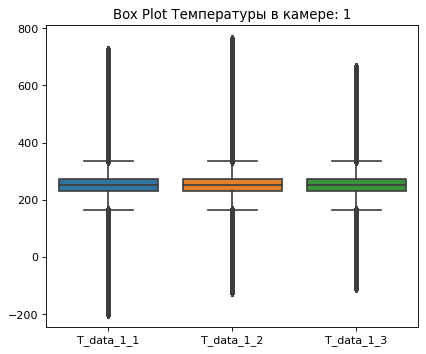

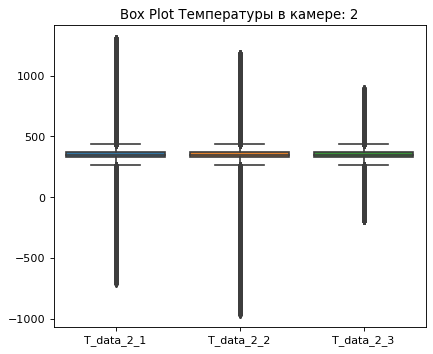

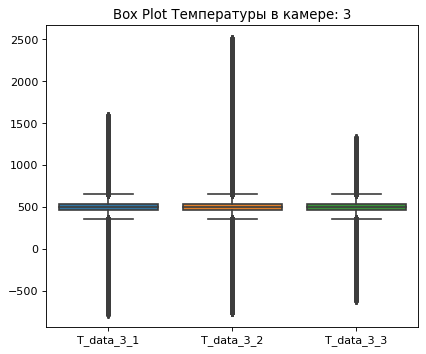

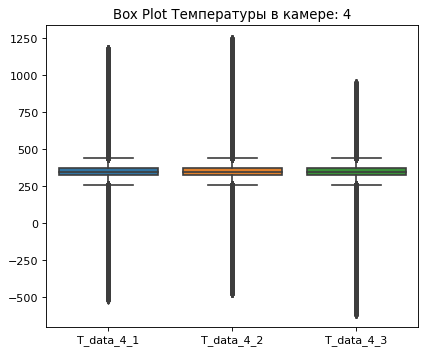

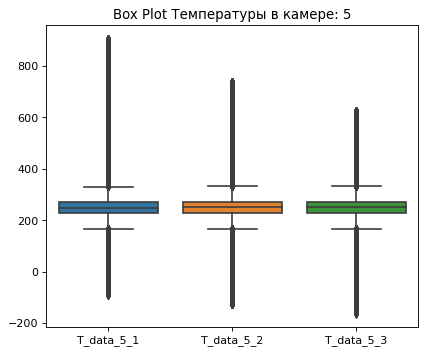

In [9]:
def features_graphs_temps_init(X):
    # -------------------------------------
    # Boxplot с температурами
    for current_chamber in range(1, 6):
        plt.figure(figsize = (6, 5), dpi = 80)
        plt.title('Box Plot Температуры в камере: '+str(current_chamber), fontsize = 12)
        sns.boxplot(data = X[['T_data_'+ str(current_chamber)+'_1',
                              'T_data_'+ str(current_chamber)+'_2',
                              'T_data_'+ str(current_chamber)+'_3']])
        plt.show()
    
features_graphs_temps_init(X_data)

### Replacing of anomalies in the temperatures. Устранение аномальных значений температур

The cause of abnormal values may be:
- sensor failure
- breakdown on another data transmission site
- incorrect polarity of the sensor connection (unlikely, because after connecting the sensor, it is always checked)

The abnormal value can be replaced by the average value of the other two working sensors in a particular camera. The average and median values of the sensors in a separate camera are almost the same.

Причиной аномальных значений может быть:
- поломка датчика
- поломка на другом участке передачи данных
- неправильная полярность подключения датчика (маловероятно, т.к. после подключения датчика он всегда проверяется)

Аномальное значение можно заменить средним значением двух других работающих датчиков в конкретной камере. Средние и медианные значения датчиков в отдельной камере практически совпадают.

In [10]:
# Значение допустимого отклонения показаний датчика в %%
tolerance = 30

# Функция корректировки значений датчиков
def sensor_check(row, column_name, column_name_supp_1, column_name_supp_2):
    curr_temp = np.abs(row[column_name])
    mean_supp_temp = (np.abs(row[column_name_supp_1])+np.abs(row[column_name_supp_2]))/2
    if (np.abs(curr_temp/mean_supp_temp-1)*100 > tolerance):
        return mean_supp_temp
    else:
        return curr_temp
    
# Функция цикла по каждому сенсору из камеры
def loop_func(current_chamber, current_sensor):
    Temp_sensors = [1, 2, 3]
    # ------------------------------------------
    # Получаем название столбца для исправления
    column_name = 'T_data_' + str(current_chamber) + '_' + str(current_sensor)
    print('Исправляем аномальные значения датчика: ', column_name)
    # ------------------------------------------
    # Получаем названия датчиков в той же камере
    Temp_sensors.remove(current_sensor)
    column_name_supp_1 = 'T_data_' + str(current_chamber) + '_' + str(Temp_sensors[0])
    column_name_supp_2 = 'T_data_' + str(current_chamber) + '_' + str(Temp_sensors[1])
    print('С помощью датчика 1: ', column_name_supp_1)
    print('С помощью датчика 2: ', column_name_supp_2)
    Temp_sensors.append(current_sensor)
    # ------------------------------------------
    X_data[column_name] = X_data.apply(sensor_check,
                                args = (column_name, column_name_supp_1, column_name_supp_2),
                                axis = 1)
    X_col_out = X_data[column_name]
    print('---------------------------')
    return X_col_out

# Распараллеливание цикла
def anom_temp_repair():
    X_data_new = pd.concat(Parallel(n_jobs = 16)(delayed(loop_func)(i, j) for i in range(1, 6) for j in range(1, 4)), axis = 1)
    X_data_new[['H_data', 'AH_data']] = X_data[['H_data', 'AH_data']]
    return X_data_new

X_data_2 = anom_temp_repair()

Correction of abnormal values on the sensors has been performed. If the value on the sensor deviates by the value of `tolerance` (measured in %), then it is replaced by the average value of the other two sensors in the camera. Calculations are parallelized, for the speed of calculations.

Выполнено исправление аномальных значений на датчиках. Если значение на датчике отклоняется на величину `tolerance` (измеряется в %), то оно заменяется средним значением двух других датчиков в камере. Вычисления распараллелены, для скорости вычислений.

### Features engineering. Генерация дополнительных признаков

In [11]:
# Функция генерирования дополнительных признаков
def features_eng(X):
    # Средняя температура в каждой камере и отношение к высоте слоя и влажности
    for current_chamber in range(1, 6):
        X['T_data_'+str(current_chamber)] = (X['T_data_'+str(current_chamber)+'_'+str(1)]+
                                             X['T_data_'+str(current_chamber)+'_'+str(2)]+
                                             X['T_data_'+str(current_chamber)+'_'+str(3)])/3
        X['T_data_'+str(current_chamber)+'_div_H'] = X['T_data_'+str(current_chamber)]/X['H_data']
        X['T_data_'+str(current_chamber)+'_div_AH'] = X['T_data_'+str(current_chamber)]/X['AH_data']
    # -------------------------------------------
    # Разница между логарифмами средних температур в камерах
    com_set = itertools.combinations(np.arange(1, 6), 2) # комбинации
    for i in com_set:
        X['T_data_'+str(i[0])+str(i[1])] = np.log(X['T_data_'+str(i[0])])-np.log(X['T_data_'+str(i[1])])
    return X

X_data_2 = features_eng(X_data_2)

Additional features were generated:
- average temperature for each chamber
- the ratio of the average temperature to the height of the layer
- ratio of average temperature to humidity
- difference between logarithms of average temperatures in all chambers

Выполнено генерирование дополнительных признаков:
- средняя температура по каждой камере
- отношение средней температуре к высоте слоя
- отношение среднеей температуры к влажности
- разница между логарифмами средних температур во всех камерах

In [12]:
X_data_2.describe()

,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,...,T_data_12,T_data_13,T_data_14,T_data_15,T_data_23,T_data_24,T_data_25,T_data_34,T_data_35,T_data_45
count,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,...,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06
mean,2.498740e+02,2.499145e+02,2.500189e+02,3.496053e+02,3.494232e+02,3.495064e+02,5.004910e+02,5.006458e+02,5.011835e+02,3.491480e+02,...,-3.377326e-01,-6.957876e-01,-3.373179e-01,1.708094e-03,-3.580550e-01,4.147258e-04,3.394407e-01,3.584697e-01,6.974957e-01,3.390260e-01
std,2.858814e+01,2.877410e+01,2.887727e+01,3.299546e+01,3.319613e+01,3.303692e+01,5.477305e+01,5.457303e+01,5.483829e+01,3.268501e+01,...,1.379929e-01,1.496663e-01,1.379749e-01,1.549967e-01,1.321718e-01,1.176618e-01,1.355410e-01,1.325293e-01,1.467616e-01,1.366593e-01
min,1.015000e+02,1.025000e+02,8.000000e+01,1.500000e+02,9.300000e+01,1.470000e+02,2.005000e+02,1.910000e+02,1.880000e+02,1.360000e+02,...,-1.130534e+00,-1.689647e+00,-1.036259e+00,-7.187896e-01,-1.252336e+00,-8.021428e-01,-4.054651e-01,-3.478834e-01,-6.982378e-02,-6.308356e-01
25%,2.290000e+02,2.280000e+02,2.290000e+02,3.280000e+02,3.280000e+02,3.280000e+02,4.630000e+02,4.630000e+02,4.640000e+02,3.270000e+02,...,-4.336116e-01,-7.994973e-01,-4.332506e-01,-1.067001e-01,-4.474985e-01,-7.783814e-02,2.460550e-01,2.690377e-01,5.968294e-01,2.434958e-01
50%,2.500000e+02,2.500000e+02,2.500000e+02,3.500000e+02,3.490000e+02,3.490000e+02,5.010000e+02,5.010000e+02,5.020000e+02,3.490000e+02,...,-3.348925e-01,-6.947060e-01,-3.340061e-01,2.828856e-03,-3.586473e-01,8.932560e-04,3.372623e-01,3.614255e-01,6.958869e-01,3.371971e-01
75%,2.710000e+02,2.710000e+02,2.710000e+02,3.720000e+02,3.720000e+02,3.710000e+02,5.380000e+02,5.370000e+02,5.380000e+02,3.710000e+02,...,-2.405641e-01,-5.921526e-01,-2.401797e-01,1.096824e-01,-2.697765e-01,7.841729e-02,4.329037e-01,4.491000e-01,7.987481e-01,4.348397e-01
max,5.210000e+02,4.955000e+02,5.295000e+02,7.495000e+02,7.980000e+02,8.095000e+02,1.523500e+03,1.033000e+03,1.487500e+03,8.140000e+02,...,4.909443e-01,2.838900e-02,6.826759e-01,7.446376e-01,3.797974e-01,9.463888e-01,1.136494e+00,1.324557e+00,1.511512e+00,1.062855e+00


In [13]:
X_data_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2103841 entries, 2015-01-01 01:00:00 to 2019-01-01 01:00:00
Data columns (total 42 columns):
 #   Column           Dtype  
---  ------           -----  
 0   T_data_1_1       float64
 1   T_data_1_2       float64
 2   T_data_1_3       float64
 3   T_data_2_1       float64
 4   T_data_2_2       float64
 5   T_data_2_3       float64
 6   T_data_3_1       float64
 7   T_data_3_2       float64
 8   T_data_3_3       float64
 9   T_data_4_1       float64
 10  T_data_4_2       float64
 11  T_data_4_3       float64
 12  T_data_5_1       float64
 13  T_data_5_2       float64
 14  T_data_5_3       float64
 15  H_data           float64
 16  AH_data          float64
 17  T_data_1         float64
 18  T_data_1_div_H   float64
 19  T_data_1_div_AH  float64
 20  T_data_2         float64
 21  T_data_2_div_H   float64
 22  T_data_2_div_AH  float64
 23  T_data_3         float64
 24  T_data_3_div_H   float64
 25  T_data_3_div_AH  float64
 26  T_data_4 

In [14]:
X_data_2.agg(['skew', 'kurtosis']).transpose()

,skew,kurtosis
T_data_1_1,-0.005294,0.442056
T_data_1_2,0.044585,0.631414
T_data_1_3,0.069301,1.086187
T_data_2_1,0.235407,4.762337
T_data_2_2,0.273985,5.889869
T_data_2_3,0.466572,7.415567
T_data_3_1,0.431305,8.093746
T_data_3_2,0.163650,2.423145
T_data_3_3,0.523849,7.868852
T_data_4_1,0.149926,4.289448


### Plotting input and output variables. Построение графиков входных и выходных переменных

#### Temperature. Температура

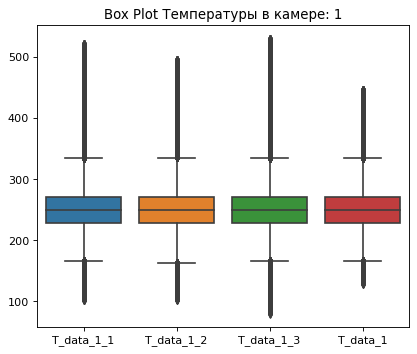

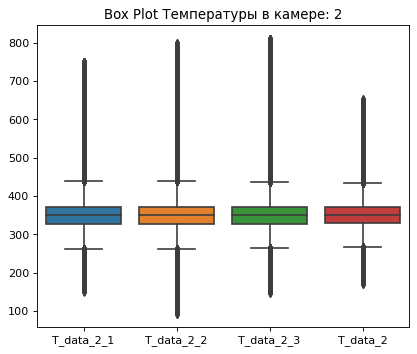

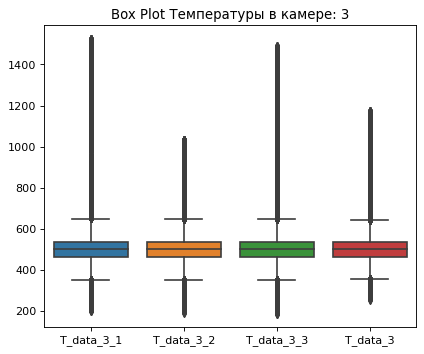

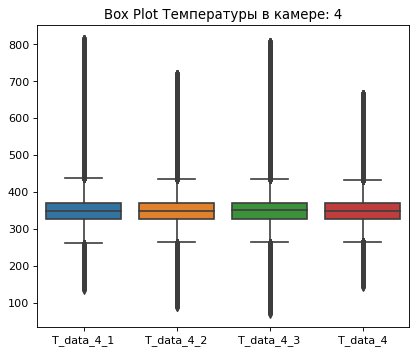

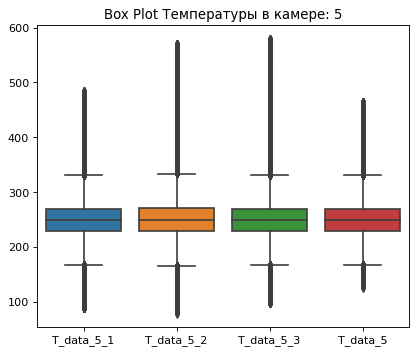

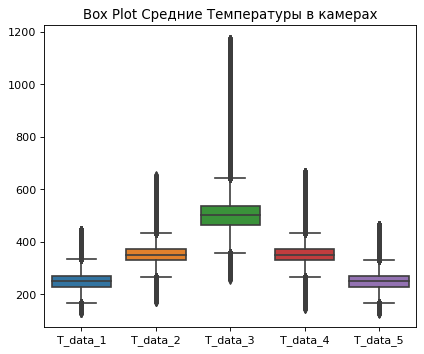

In [15]:
def features_graphs_temps(X):
    # -------------------------------------
    # Boxplot с температурами
    for current_chamber in range(1, 6):
        plt.figure(figsize = (6, 5), dpi = 80)
        plt.title('Box Plot Температуры в камере: '+str(current_chamber), fontsize = 12)
        sns.boxplot(data = X[['T_data_'+ str(current_chamber)+'_1',
                              'T_data_'+ str(current_chamber)+'_2',
                              'T_data_'+ str(current_chamber)+'_3',
                              'T_data_'+ str(current_chamber)]])
        plt.show()
    # -------------------------------------
    plt.figure(figsize = (6, 5), dpi = 80)
    plt.title('Box Plot Средние Температуры в камерах', fontsize = 12)
    sns.boxplot(data = X[['T_data_1',
                          'T_data_2',
                          'T_data_3',
                          'T_data_4',
                          'T_data_5']])
    plt.show()
    
features_graphs_temps(X_data_2)

The graphs of the corrected temperature show that the negative values have disappeared, the variance has decreased.

Also, the variance of values for the average temperature in the chamber is lower than for individual sensors (with the exception of the 3rd chamber).

The general graph of average temperatures shows that the temperatures at the inlet and outlet of the roasting machine are minimal, and in the 3rd chamber the maximum.

На графиках исправленной температуры видно, что исчезли отрицательные значения, уменьшилась дисперсия.

Так же дисперсия значений для средней температуры в камере ниже, чем по датчикам отдельности (за исключением 3-й камеры).

Общий график средних температур показывает, что на входе и на выходе из обжиговой машины температуры минимальны, а в 3-й камере максимум.

#### Layer height. Высота слоя

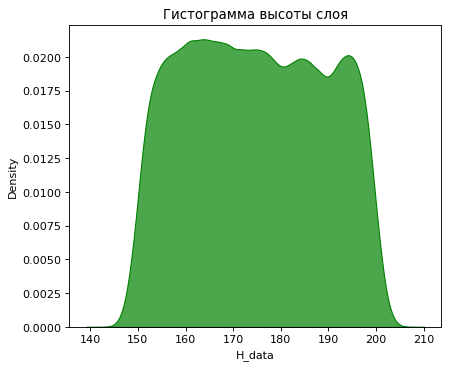

count    2.103841e+06
mean     1.747170e+02
std      1.443613e+01
min      1.414900e+02
25%      1.624400e+02
50%      1.744000e+02
75%      1.870100e+02
max      2.078300e+02
Name: H_data, dtype: float64

In [16]:
plt.figure(figsize = (6, 5), dpi = 80)
plt.title('Гистограмма высоты слоя', fontsize = 12)
sns.kdeplot(X_data_2['H_data'], shade = True, color = "g", alpha = .7)
plt.show()
X_data_2['H_data'].describe()

#### Raw material humidity. Влажность сырья

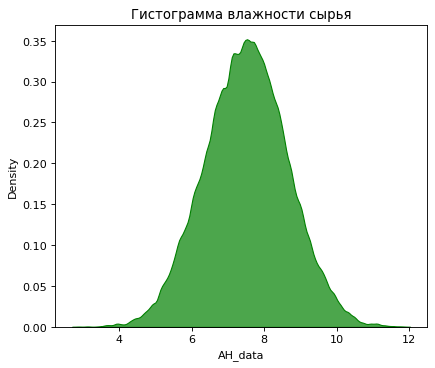

count    2.103841e+06
mean     7.499369e+00
std      1.148026e+00
min      2.890000e+00
25%      6.730000e+00
50%      7.510000e+00
75%      8.270000e+00
max      1.184000e+01
Name: AH_data, dtype: float64

In [17]:
plt.figure(figsize = (6, 5), dpi = 80)
plt.title('Гистограмма влажности сырья', fontsize = 12)
sns.kdeplot(X_data_2['AH_data'], shade = True, color = "g", alpha = .7)
plt.show()
X_data_2['AH_data'].describe()

#### The ratio of the average temperature in the chamber to the height of the layer. Отношение средней температуры в камере к высоте слоя

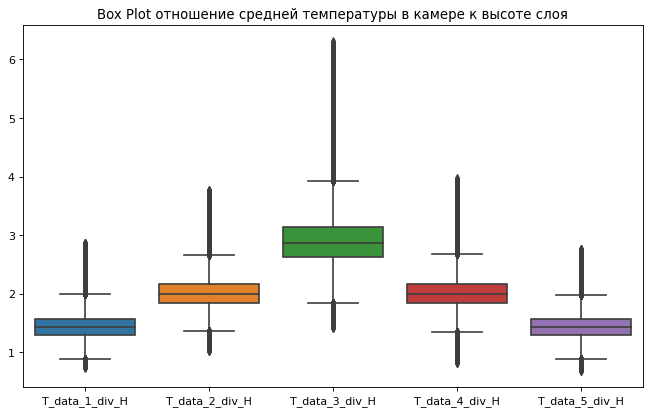

In [18]:
plt.figure(figsize = (10, 6), dpi = 80)
plt.title('Box Plot отношение средней температуры в камере к высоте слоя', fontsize = 12)
sns.boxplot(data = X_data_2[['T_data_1_div_H',
                             'T_data_2_div_H',
                             'T_data_3_div_H',
                             'T_data_4_div_H',
                             'T_data_5_div_H']])
plt.show()

#### The ratio of the average temperature in the chamber to the humidity of the raw material. Отношение средней температуры в камере к влажности сырья

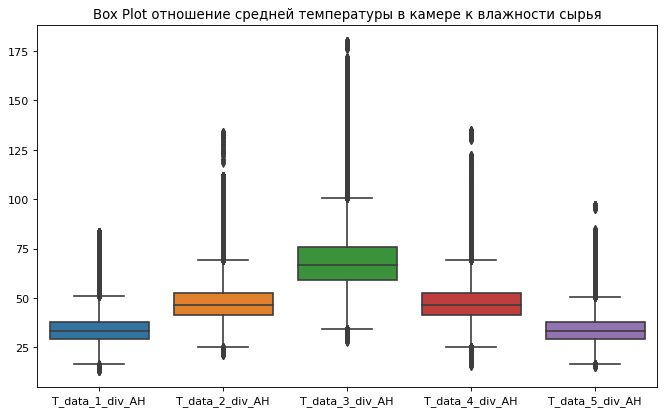

In [19]:
plt.figure(figsize = (10, 6), dpi = 80)
plt.title('Box Plot отношение средней температуры в камере к влажности сырья', fontsize = 12)
sns.boxplot(data = X_data_2[['T_data_1_div_AH',
                             'T_data_2_div_AH',
                             'T_data_3_div_AH',
                             'T_data_4_div_AH',
                             'T_data_5_div_AH']])
plt.show()

#### The difference between the average temperatures in the chambers. Разница между средними температурами в камерах

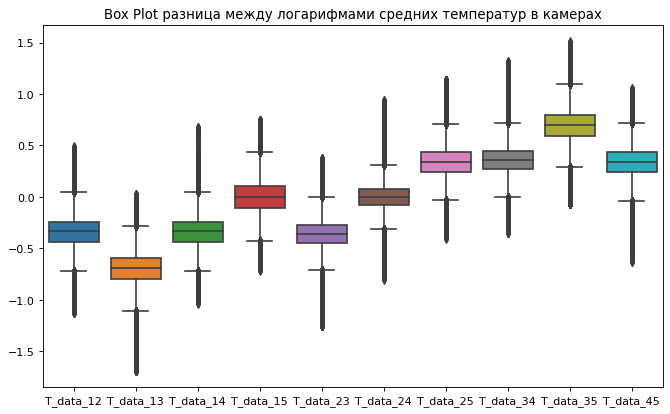

In [20]:
com_set = itertools.combinations(np.arange(1, 6), 2)
cols_diff_temp = []
for i in com_set:
    cols_diff_temp.append('T_data_'+str(i[0])+str(i[1]))
    
plt.figure(figsize = (10, 6), dpi = 80)
plt.title('Box Plot разница между логарифмами средних температур в камерах', fontsize = 12)
sns.boxplot(data = X_data_2[cols_diff_temp])
plt.show()

The graphs above show that they need further scaling and elimination of emissions. This will be done after the formation of the training and test sets.

На приведенных выше графиках видно, что они нуждаются в дальнейшем масштабировании и устранении выбросов. Это будет выполнено после формирования обучающего и тестового множеств.

#### Product quality (target variable). Качество продукции (выходная переменная)

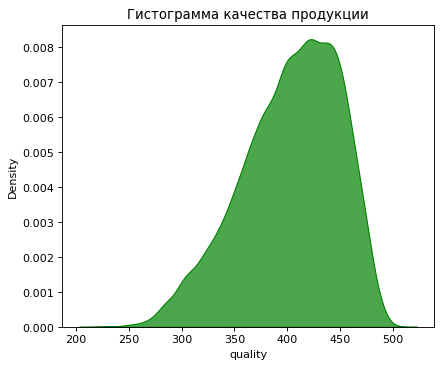

count    29184.000000
mean       402.800747
std         46.273228
min        221.000000
25%        372.000000
50%        408.000000
75%        439.000000
max        505.000000
Name: quality, dtype: float64


In [21]:
plt.figure(figsize = (6, 5), dpi = 80)
plt.title('Гистограмма качества продукции', fontsize = 12)
sns.kdeplot(Y_train['quality'], shade = True, color = "g", alpha = .7)
plt.show()
print(Y_train['quality'].describe())

The target variable has a left asymmetry.

Целевая переменная имеет левую ассимметрию.

## Formation of training and test sets. Формирование обучающего и тестового множеств

### Training and validation set. Обучающее и валидационное множество

In [22]:
train_val_idx = Y_train.index
features_train_val = X_data_2.loc[train_val_idx]
target_train_val = Y_train
features_train_val.describe()

,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,...,T_data_12,T_data_13,T_data_14,T_data_15,T_data_23,T_data_24,T_data_25,T_data_34,T_data_35,T_data_45
count,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,...,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000
mean,249.731394,249.702560,249.855520,349.712891,349.459618,349.602419,500.402841,500.506236,501.003735,348.839981,...,-0.338583,-0.696131,-0.336825,0.000745,-0.357548,0.001758,0.339328,0.359307,0.696876,0.337569
std,28.461665,28.782251,28.811502,33.227840,33.473224,33.382627,55.063630,54.711726,54.990993,32.770286,...,0.137623,0.149904,0.137938,0.155220,0.132607,0.118185,0.136289,0.133511,0.147012,0.136358
min,108.500000,103.500000,89.500000,154.500000,149.000000,165.000000,207.000000,212.500000,196.500000,158.500000,...,-1.091874,-1.686684,-0.988209,-0.643667,-1.250913,-0.646508,-0.364325,-0.281984,-0.068272,-0.521960
25%,228.000000,228.000000,229.000000,328.000000,328.000000,328.000000,463.000000,463.000000,464.000000,327.000000,...,-0.434289,-0.800666,-0.432782,-0.108760,-0.447167,-0.075575,0.245424,0.269318,0.595540,0.241975
50%,250.000000,250.000000,250.000000,350.000000,349.500000,350.000000,501.000000,502.000000,502.000000,349.000000,...,-0.336081,-0.695507,-0.333718,0.000000,-0.357393,0.002004,0.337039,0.362289,0.695071,0.335913
75%,271.000000,271.000000,271.000000,372.000000,372.000000,371.000000,537.000000,537.000000,538.000000,371.000000,...,-0.242009,-0.591387,-0.240072,0.109521,-0.268757,0.080342,0.432671,0.450756,0.798430,0.433819
max,439.000000,488.000000,495.000000,749.000000,793.500000,808.000000,1516.000000,1022.500000,1485.500000,794.000000,...,0.334866,-0.062520,0.598263,0.656949,0.316337,0.865838,1.131717,1.290492,1.471572,0.972044


### Test set. Тестовое множество

In [23]:
test_idx = Y_submit.index
features_test = X_data_2.loc[test_idx]
features_test.describe()

,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,...,T_data_12,T_data_13,T_data_14,T_data_15,T_data_23,T_data_24,T_data_25,T_data_34,T_data_35,T_data_45
count,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,...,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000
mean,250.526257,250.783919,250.546488,349.045971,349.116736,349.145489,500.571539,501.121815,501.543044,351.085916,...,-0.334058,-0.693991,-0.340909,0.006206,-0.359933,-0.006851,0.340264,0.353082,0.700197,0.347115
std,28.957835,28.762451,29.374443,32.538783,32.642399,31.473791,53.211406,53.504273,54.400834,31.747165,...,0.140417,0.149047,0.137265,0.153575,0.130393,0.115462,0.133020,0.127201,0.146075,0.137612
min,109.500000,119.000000,106.000000,196.500000,175.000000,190.000000,233.000000,232.500000,229.500000,163.500000,...,-0.891153,-1.298533,-0.955331,-0.590904,-0.953091,-0.514618,-0.146854,-0.180706,0.107760,-0.243312
25%,229.000000,229.000000,229.000000,327.000000,327.000000,327.000000,463.000000,465.000000,465.000000,330.000000,...,-0.429824,-0.795511,-0.435815,-0.094648,-0.449979,-0.087823,0.249888,0.267938,0.600324,0.251591
50%,251.000000,251.000000,252.000000,349.000000,349.000000,349.000000,500.000000,500.000000,500.000000,351.000000,...,-0.329300,-0.693774,-0.336763,0.013811,-0.361709,-0.008251,0.339767,0.358079,0.700346,0.342934
75%,271.000000,272.000000,272.000000,372.000000,372.000000,372.000000,539.000000,538.000000,538.000000,373.000000,...,-0.234311,-0.592510,-0.244054,0.109360,-0.272480,0.068929,0.432984,0.439062,0.802142,0.442677
max,521.000000,382.000000,529.500000,610.500000,618.500000,566.500000,869.500000,912.500000,922.500000,594.500000,...,0.146093,-0.072407,0.408457,0.742909,0.234063,0.525965,0.918116,0.947271,1.320567,0.975915


The formation of training and test sets has been performed.

Выполнено формирование обучающего и тестового множеств.

### Scaling of features into a single interval. Масштабирование признаков в единичный интервал

#### Train set. Обучающее множество

In [24]:
scaler = MinMaxScaler()
features_train_val_mapped = scaler.fit_transform(features_train_val)
features_train_val_mapped = pd.DataFrame(features_train_val_mapped+1, columns = features_train_val.columns, index = train_val_idx)

In [25]:
features_train_val_mapped.describe()

,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,...,T_data_12,T_data_13,T_data_14,T_data_15,T_data_23,T_data_24,T_data_25,T_data_34,T_data_35,T_data_45
count,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,...,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000
mean,1.427326,1.380241,1.395451,1.328365,1.311031,1.287096,1.224143,1.355563,1.236233,1.299512,...,1.527981,1.609885,1.410587,1.495466,1.570020,1.428650,1.470343,1.407822,1.496900,1.575319
std,0.086117,0.074856,0.071052,0.055892,0.051937,0.051917,0.042065,0.067545,0.042662,0.051566,...,0.096460,0.092296,0.086946,0.119344,0.084611,0.078147,0.091099,0.084905,0.095472,0.091270
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.361573,1.323797,1.344020,1.291842,1.277735,1.253499,1.195569,1.309259,1.207525,1.265146,...,1.460900,1.545523,1.350102,1.411272,1.512838,1.377515,1.407575,1.350595,1.431090,1.511335
50%,1.428139,1.381014,1.395808,1.328848,1.311094,1.287714,1.224599,1.357407,1.237005,1.299764,...,1.529734,1.610269,1.412545,1.494894,1.570120,1.428812,1.468813,1.409718,1.495727,1.574211
75%,1.491679,1.435631,1.447596,1.365854,1.346005,1.320373,1.252101,1.400617,1.264934,1.334382,...,1.595669,1.674376,1.471573,1.579101,1.626675,1.480611,1.532736,1.465978,1.562850,1.639744
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


#### Test set. Тестовое множество

In [26]:
features_test_mapped = scaler.transform(features_test)
features_test_mapped = pd.DataFrame(features_test_mapped+1, columns = features_test.columns, index = test_idx)

This scaling and offset by one in the positive direction is necessary for the application of the boxcox transformation.

Данное масштабирование и смещение на единицу в положительную сторону необходимо для применения boxcox преобразования.

### Boxcox transformation of input features for training and test sets. Boxcox преобразование входных признаков для обучающего и тестового множеств

In [27]:
lambda_bx = np.zeros(len(features_train_val_mapped.columns))
n = 0
for col in features_train_val_mapped.columns:
    features_train_val_mapped[col], lambda_bx[n] = st.boxcox(features_train_val_mapped[col])
    features_test_mapped[col] = st.boxcox(features_test_mapped[col], lambda_bx[n])
    n += 1

In [28]:
features_train_val_mapped.agg(['skew', 'kurtosis']).transpose()

,skew,kurtosis
T_data_1_1,0.001925,0.093769
T_data_1_2,0.008072,0.676247
T_data_1_3,0.010133,0.789156
T_data_2_1,0.030795,4.494013
T_data_2_2,0.033645,5.391099
T_data_2_3,-0.005118,5.525142
T_data_3_1,-0.018472,3.439755
T_data_3_2,0.014849,1.911837
T_data_3_3,-0.027178,2.911739
T_data_4_1,0.019798,3.636328


### Standard scaler. Масштабирование дисперсии.

#### Train set. Обучающее множество

In [29]:
scaler_2 = StandardScaler()
features_train_val_mapped = np.tanh(scaler.fit_transform(features_train_val_mapped))
features_train_val_mapped = pd.DataFrame(features_train_val_mapped, columns = features_train_val.columns, index = train_val_idx)

#### Test set. Тестовое множество

In [30]:
features_test_mapped = np.tanh(scaler.transform(features_test_mapped))
features_test_mapped = pd.DataFrame(features_test_mapped, columns = features_test.columns, index = test_idx)

In this block, scaling by unit variance and setting the average to zero is performed. The values are also passed through tanh() to remove outliers in the data.

В данном блоке выполнено масштабирование на единичную дисперсию и установление среднего на нуль. Так же значения пропущены через tanh() для нивелирования выбросов в данных.

## Search for informative inputs. Поиск информативных входов

### Correlation. График корреляций

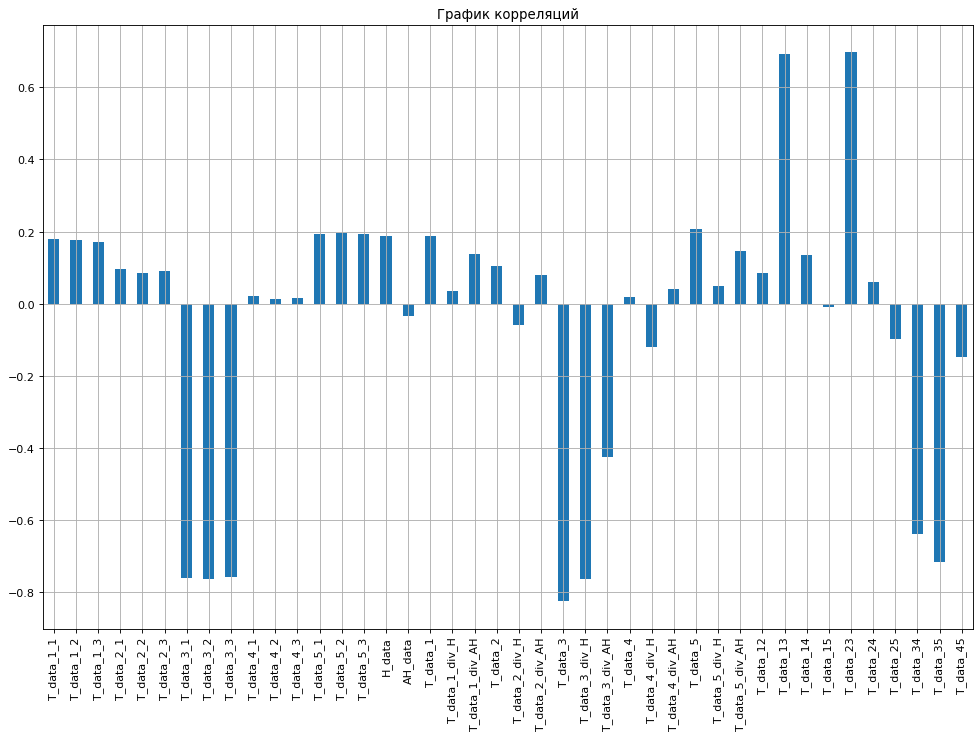

In [31]:
def feat_selection(features, target):
    full_df = pd.concat([features, target], axis = 1)
    # Коэффициент корреляции
    corr_coeff_all = full_df.corr()
    corr_coeff = corr_coeff_all[corr_coeff_all.columns[-1]]
    corr_coeff.drop(corr_coeff.tail(1).index, inplace = True)
    plt.figure(figsize = (15, 10), dpi= 80)
    plt.title('График корреляций', fontsize = 12)
    corr_coeff.plot(kind = 'bar', grid = True)
    plt.show()
    
feat_selection(features_train_val_mapped, target_train_val)

The correlation graph shows the linear dependence of the target variable on each feature separately. In order to study the mutual influence of features, we will get their significance for the basic RandomForest and CatBoost models.

На графике корреляций видна линейная зависимость целевой переменной от каждого признака в отдельности. Для того чтоб изучить взаимное влияние признаков получим их значимость для базовых моделей RandomForest и CatBoost.

### RandomForestRegressor

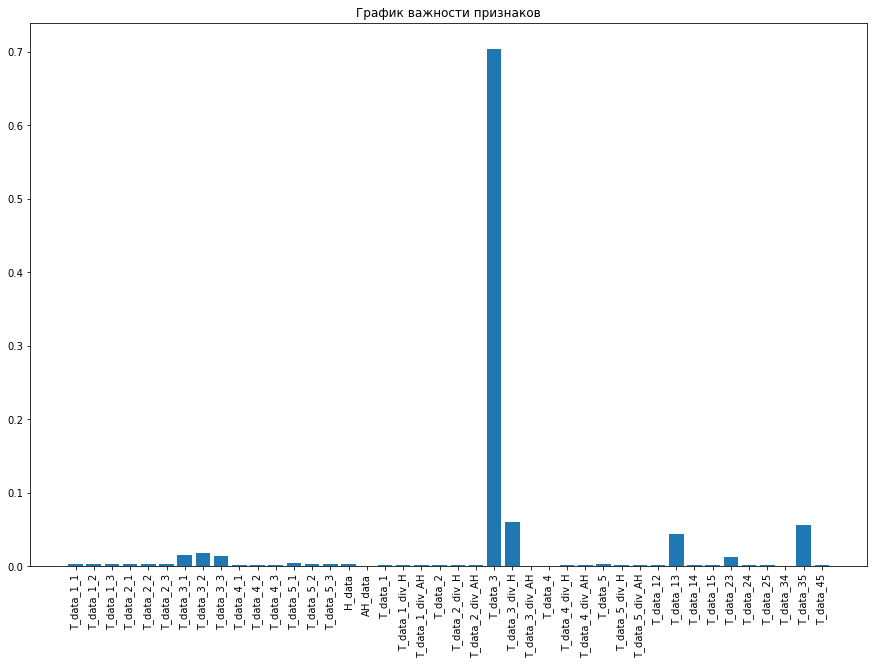

In [32]:
def feat_selection_rf(features, target):
    rgr = RandomForestRegressor(n_jobs = -1)
    rgr.fit(features, np.ravel(target))
    plt.figure(figsize = (15, 10))
    plt.title('График важности признаков', fontsize = 12)
    plt.bar(features.columns, rgr.feature_importances_)
    plt.xticks(rotation = 90)
    
feat_selection_rf(features_train_val_mapped, target_train_val)

For a Random Forest, the most important feature was the average temperature in the third chamber. Moreover, the correlation is negative. The high temperature in the third chamber negatively affects the quality.

Для случайного леса самым важным признаком оказалась средняя температура в третьей камере. Причем корреляция отрицательная. Большая температура в третьей камере негативно влияет на качество.

### CatBoostRegressor

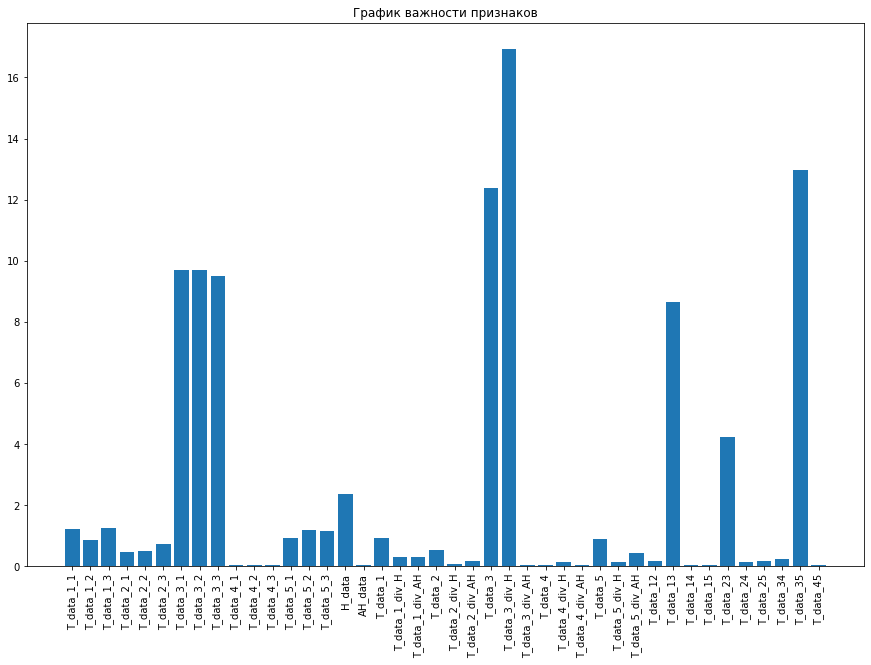

In [33]:
def feat_selection_cb(features, target):
    rgr = CatBoostRegressor(loss_function = "MAE")
    rgr.fit(features, target, silent = True)
    plt.figure(figsize = (15, 10))
    plt.title('График важности признаков', fontsize = 12)
    plt.bar(features.columns, rgr.feature_importances_)
    plt.xticks(rotation = 90)
    
feat_selection_cb(features_train_val_mapped, target_train_val)

#### Significant signs (> 2%). Оставляем значимые признаки ( > 2% значимости)

In [34]:
features_important = ['T_data_3_1',
                      'T_data_3_2',
                      'T_data_3_3',
                      'H_data',
                      'T_data_3',
                      'T_data_3_div_H',
                      'T_data_13',
                      'T_data_23',
                      'T_data_35']

For CatBoost, the model revealed a more complex relationship of input features, but the average temperature in the third chamber is still the most significant of them. The temperature in the fourth chamber was the least significant. Next, we apply the Principal Component Analysis method to isolate a small number of significant variables.

Для CatBoost модель выявила более сложную взаимосвязь входных признаков, но средняя температура в третьей камере всё равно является самым значимым из них. Самой малозначимой оказалась температура в четвертой камере. Далее применим метод Анализа Главных Компонент для выделения небольшого количества значимых переменных.

### PCA

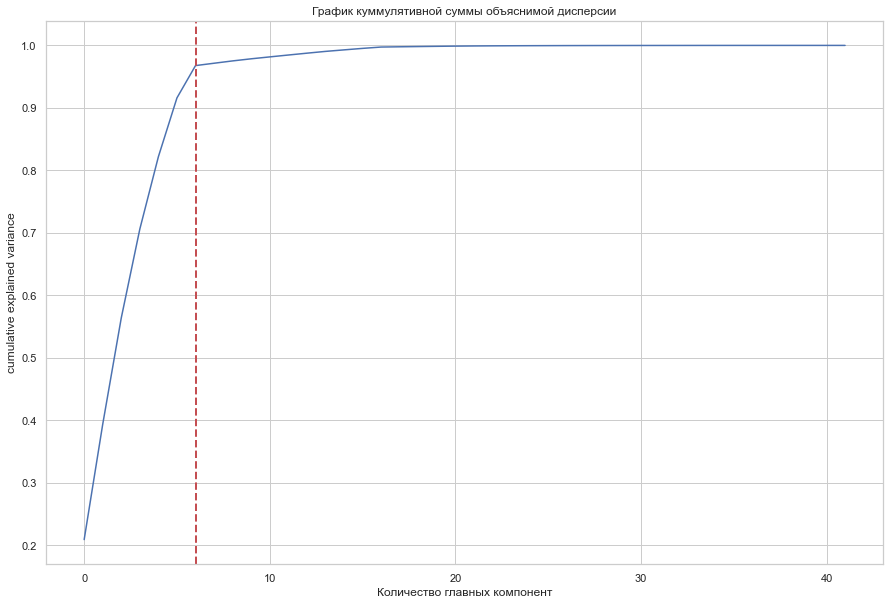

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.209367,0.209367
1,0.393948,0.184581
2,0.564123,0.170175
3,0.706285,0.142163
4,0.822010,0.115725
5,0.916056,0.094046
6,0.967719,0.051662
7,0.971478,0.003760
8,0.975207,0.003729
9,0.978572,0.003365


In [35]:
pca_test = PCA(n_components = len(features_train_val_mapped.columns))
pca_test.fit(features_train_val_mapped)
sns.set(style = 'whitegrid')
plt.figure(figsize = (15, 10))
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.title('График куммулятивной суммы объяснимой дисперсии', fontsize = 12)
plt.xlabel('Количество главных компонент')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth = 2, color = 'r', linestyle = '--', x = 6, ymin = 0, ymax = 1)
plt.show()
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

The first 6 main components explain 98% of the variance in the data, the remaining components explain less than 2% of the variance.

Первые 6 главных компонент объясняют 98% дисперсии в данных, оставшиеся компоненты объясняют менее 2% дисперсии.

In [36]:
pca = PCA(n_components = 6)
pca.fit(features_train_val_mapped)
features_train_val_mapped_pca = pca.transform(features_train_val_mapped)
features_test_mapped_pca  = pca.transform(features_test_mapped)

## Training of models. Обучение моделей

### Dividing for train and validation sets. Разделение на обучающее и валидационное множества исходных входов и масштабированных

In [37]:
random_state = 12345
test_size = 0.2
shuffle = True
features_train, features_val, target_train, target_val = train_test_split(
    features_train_val, target_train_val, test_size = test_size, shuffle = shuffle, random_state = random_state)

In [38]:
features_train_mapped, features_val_mapped, _, _ = train_test_split(
    features_train_val_mapped, target_train_val, test_size = test_size, shuffle = shuffle, random_state = random_state)

In [39]:
features_train_mapped_pca, features_val_mapped_pca, _, _ = train_test_split(
    features_train_val_mapped_pca, target_train_val, test_size = test_size, shuffle = shuffle, random_state = random_state)

I made a division into a training and validation set. The parameter `shuffle = True`, because the parameter of a stationary system (roasting machine) is predicted, which does not evolve over time. Directly during the training of models, cross-validation in `GridSearchCV` will be used to find optimal parameters. But, since parallelization is started, it is not always possible to get results on cross-validation. Therefore, the optimal model will be retrained on the set of `train+val`.

Сделал разделение на обучающее и валидационное множество. Параметр `shuffle = True`, т.к. прогнозируется параметр стационарной системы (обжиговой машины), которая не эволюционирует во времени. Непосредственно при обучениях моделей будет использована кросс-валидация в `GridSearchCV` для поиска оптимальных параметров. Но, т.к. запускается распараллеливание, то не всегда есть возможность получить результаты на кросс-валидации. Поэтому оптимальная модель будет переобучена на множестве `train+val`.

### DummyRegressor

In [40]:
def result_of_DummyRegressor(features, target):
    # -------------------------------------------------------
    # Тип модели и её параметры
    best_model = DummyRegressor(strategy = "median")
    # -------------------------------------------------------
    best_model.fit(features, target)
    # -------------------------------------------------------
    # Моделирование и метрики
    predictions = best_model.predict(features)
    MAE = mean_absolute_error(target, predictions)
    print('MAE модели регрессии на обучающей выборке:', MAE)
    print("Коэффициент детерминации на обучающей выборке:", r2_score(target, predictions))
    # -------------------------------------------------------
    # Строим график
    plt.scatter(target, predictions, color = 'black')
    plt.xlabel('Target')
    plt.ylabel('Predictions')
    plt.title('График Target-Predictions на обучающей выборке')
    plt.show()
    return best_model, MAE

MAE модели регрессии на обучающей выборке: 37.41474279350666
Коэффициент детерминации на обучающей выборке: -0.01617542999524124


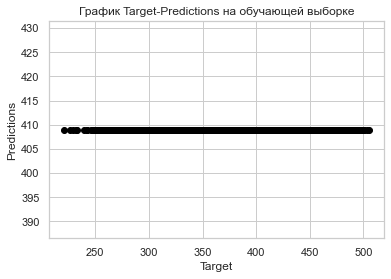

In [41]:
model_Dummy, MAE_Dummy_train = result_of_DummyRegressor(features_train_mapped, target_train)

In [42]:
def best_model_simulation(model, features, target):
    # -------------------------------------------------------
    # Моделирование и метрики
    predictions = model.predict(features)
    MAE = mean_absolute_error(target, predictions)
    print('MAE модели регрессии на обучающей выборке:', MAE)
    print("Коэффициент детерминации на обучающей выборке:", r2_score(target, predictions))
    # -------------------------------------------------------
    # Строим график
    plt.scatter(target, predictions, color = 'black')
    plt.xlabel('Target')
    plt.ylabel('Predictions')
    plt.title('График Target-Predictions на обучающей выборке')
    plt.show()
    return MAE

MAE модели регрессии на обучающей выборке: 38.17252013020387
Коэффициент детерминации на обучающей выборке: -0.02591866259984621


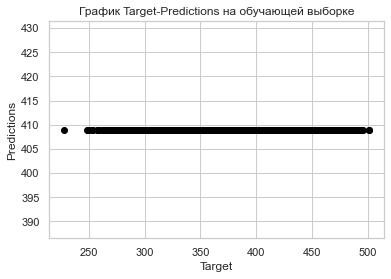

In [43]:
MAE_Dummy_val = best_model_simulation(model_Dummy, features_val_mapped, target_val)

Сделана модель наивного регрессора.

### LinearRegressor

In [44]:
def best_params_LinearRegression(features, target):
    # -------------------------------------------------------
    # Обучение модели
    best_model = LinearRegression()
    best_model.fit(features, target)
    # -------------------------------------------------------
    # Моделирование и метрики
    predictions = best_model.predict(features)
    MAE = mean_absolute_error(target, predictions)
    print('MAE модели регрессии на обучающей выборке:', MAE)
    print("Коэффициент детерминации на обучающей выборке:", r2_score(target, predictions))
    # -------------------------------------------------------
    # Строим график
    plt.scatter(target, predictions, color = 'black')
    plt.xlabel('Target')
    plt.ylabel('Predictions')
    plt.title('График Target-Predictions на обучающей выборке')
    plt.show()
    return best_model, MAE

#### Without scaling. Без масштабирования

MAE модели регрессии на обучающей выборке: 13.327808422888983
Коэффициент детерминации на обучающей выборке: 0.8115351966746533


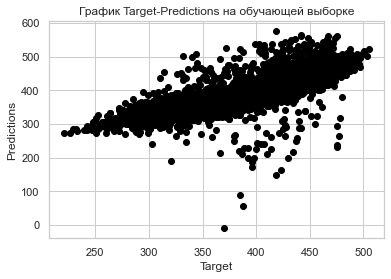

In [45]:
model_LR_1, MAE_LR_train_1 = best_params_LinearRegression(features_train, target_train)

MAE модели регрессии на обучающей выборке: 13.050814912528121
Коэффициент детерминации на обучающей выборке: 0.8490619011137


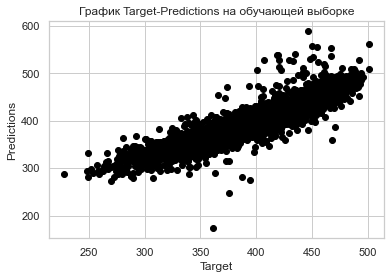

In [46]:
MAE_LR_val_1 = best_model_simulation(model_LR_1, features_val, target_val)

#### Scaled. Масштабированные

MAE модели регрессии на обучающей выборке: 12.240414757193145
Коэффициент детерминации на обучающей выборке: 0.8405182236324281


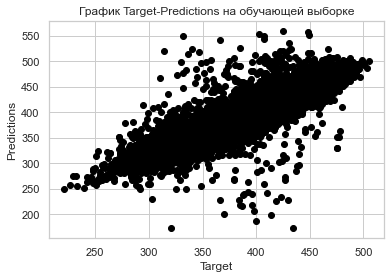

In [47]:
model_LR_2, MAE_LR_train_2 = best_params_LinearRegression(features_train_mapped, target_train)

MAE модели регрессии на обучающей выборке: 12.093495327935319
Коэффициент детерминации на обучающей выборке: 0.8684661421546862


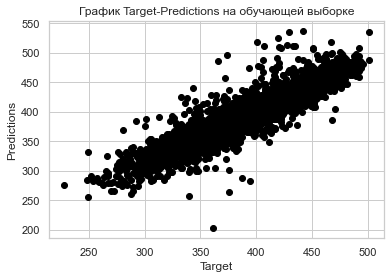

In [48]:
MAE_LR_val_2 = best_model_simulation(model_LR_2, features_val_mapped, target_val)

#### Scaled, important features. Масштабированные, наиболее значимые признаки

MAE модели регрессии на обучающей выборке: 13.937353571516503
Коэффициент детерминации на обучающей выборке: 0.8071614497413452


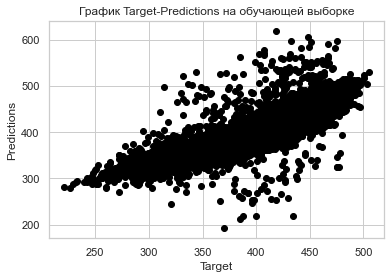

In [49]:
model_LR_3, MAE_LR_train_3 = best_params_LinearRegression(features_train_mapped[features_important], target_train)

MAE модели регрессии на обучающей выборке: 13.633469000899188
Коэффициент детерминации на обучающей выборке: 0.8320815478240575


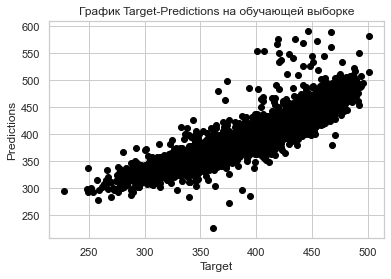

In [50]:
MAE_LR_val_3 = best_model_simulation(model_LR_3, features_val_mapped[features_important], target_val)

#### PCA

MAE модели регрессии на обучающей выборке: 15.291989531046177
Коэффициент детерминации на обучающей выборке: 0.7840920269792448


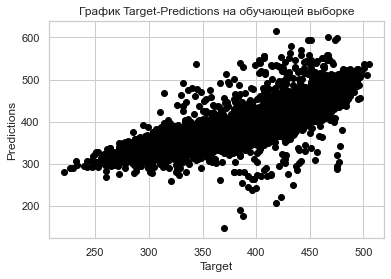

In [51]:
model_LR_4, MAE_LR_train_4 = best_params_LinearRegression(features_train_mapped_pca, target_train)

MAE модели регрессии на обучающей выборке: 15.03835997682895
Коэффициент детерминации на обучающей выборке: 0.8091231302845602


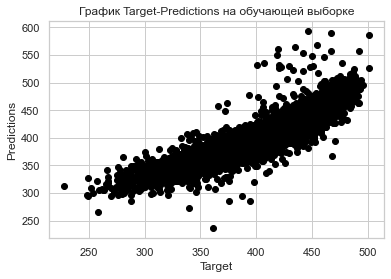

In [52]:
MAE_LR_val_4 = best_model_simulation(model_LR_4, features_val_mapped_pca, target_val)

### RandomForestRegressor

#### Without scaling. Без масштабирования

Лучшие параметры: {'max_depth': 9, 'n_estimators': 10}
MAE модели регрессии на обучающей выборке: 9.488744716275768
Коэффициент детерминации на обучающей выборке: 0.9264733886875531


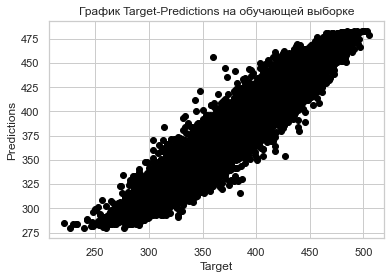

In [54]:
model_RF_1, MAE_RF_train_1 = best_params_RandomForestRegression(features_train, target_train)

MAE модели регрессии на обучающей выборке: 11.280074080091664
Коэффициент детерминации на обучающей выборке: 0.893415689785138


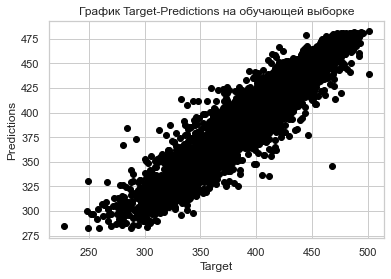

In [55]:
MAE_RF_val_1 = best_model_simulation(model_RF_1, features_val, target_val)

#### Scaled. Масштабированные

Лучшие параметры: {'max_depth': 9, 'n_estimators': 10}
MAE модели регрессии на обучающей выборке: 9.486452716696274
Коэффициент детерминации на обучающей выборке: 0.9265138201558475


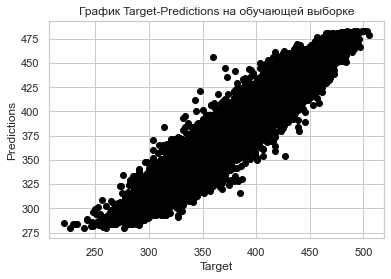

In [56]:
model_RF_2, MAE_RF_train_2 = best_params_RandomForestRegression(features_train_mapped, target_train)

MAE модели регрессии на обучающей выборке: 11.277132479231993
Коэффициент детерминации на обучающей выборке: 0.8936180673915153


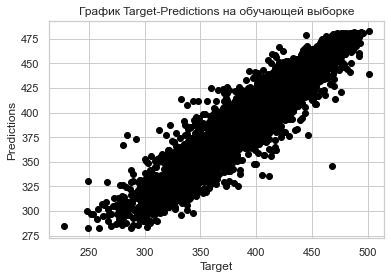

In [57]:
MAE_RF_val_2 = best_model_simulation(model_RF_2, features_val_mapped, target_val)

#### Scaled, important features. Масштабированные, наиболее значимые признаки

Лучшие параметры: {'max_depth': 9, 'n_estimators': 10}
MAE модели регрессии на обучающей выборке: 9.650761529619077
Коэффициент детерминации на обучающей выборке: 0.9237642329684453


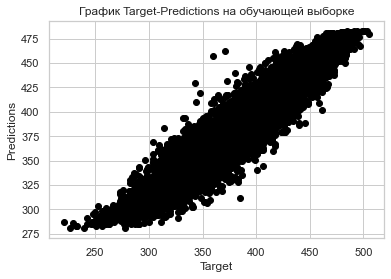

In [58]:
model_RF_3, MAE_RF_train_3 = best_params_RandomForestRegression(features_train_mapped[features_important], target_train)

MAE модели регрессии на обучающей выборке: 11.276629567730268
Коэффициент детерминации на обучающей выборке: 0.8937486492733429


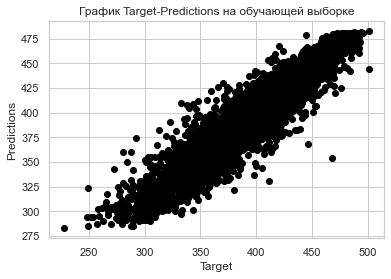

In [59]:
MAE_RF_val_3 = best_model_simulation(model_RF_3, features_val_mapped[features_important], target_val)

#### PCA

Лучшие параметры: {'max_depth': 9, 'n_estimators': 10}
MAE модели регрессии на обучающей выборке: 12.136745236768833
Коэффициент детерминации на обучающей выборке: 0.8748375569655326


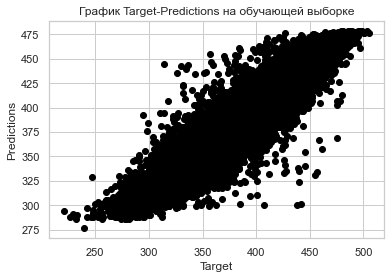

In [60]:
model_RF_4, MAE_RF_train_4 = best_params_RandomForestRegression(features_train_mapped_pca, target_train)

MAE модели регрессии на обучающей выборке: 13.573056909219863
Коэффициент детерминации на обучающей выборке: 0.8482343727426629


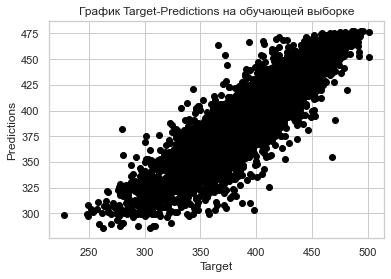

In [61]:
MAE_RF_val_4 = best_model_simulation(model_RF_4, features_val_mapped_pca, target_val)

### CatBoostRegressor

In [62]:
def best_params_CatBoostRegressor(features, target):
    # -------------------------------------------------------
    # Тип модели и её параметры
    model = CatBoostRegressor(silent = True)
    parameters = {'learning_rate': [0.03, 0.1],
                  'depth': [4, 10],
                  'l2_leaf_reg': [3, 9]}
    # -------------------------------------------------------
    MAE_s = make_scorer(mean_absolute_error, greater_is_better = False)
    grid = GridSearchCV(model, parameters, scoring = MAE_s, cv = 5, n_jobs = -1)
    grid.fit(features, target)
    print('Лучшие параметры:', grid.best_params_)       
    # -------------------------------------------------------
    # Обучение модели
    best_model = CatBoostRegressor(learning_rate = grid.best_params_['learning_rate'],
                                   depth = grid.best_params_['depth'],
                                   l2_leaf_reg = grid.best_params_['l2_leaf_reg'],
                                   loss_function = 'MAE',
                                   silent = True,
                                   random_state = random_state)
    best_model.fit(features, target, plot = True)
    # -------------------------------------------------------
    # Моделирование и метрики
    predictions = best_model.predict(features)
    MAE = mean_absolute_error(target, predictions)
    print('MAE модели регрессии на обучающей выборке:', MAE)
    print("Коэффициент детерминации на обучающей выборке:", r2_score(target, predictions))
    # -------------------------------------------------------
    # Строим график
    plt.scatter(target, predictions, color='black')
    plt.xlabel('Target')
    plt.ylabel('Predictions')
    plt.title('График Target-Predictions на обучающей выборке')
    plt.show()
    return best_model, MAE

#### Without scaling. Без масштабирования

Лучшие параметры: {'depth': 10, 'l2_leaf_reg': 9, 'learning_rate': 0.1}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAE модели регрессии на обучающей выборке: 3.761015437973286
Коэффициент детерминации на обучающей выборке: 0.9806159264992736


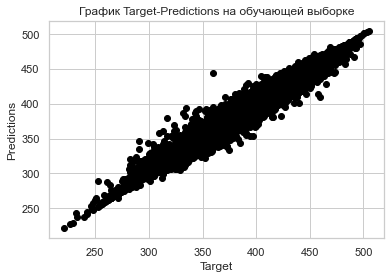

In [63]:
model_CB_1, MAE_CB_train_1 = best_params_CatBoostRegressor(features_train, target_train)

MAE модели регрессии на обучающей выборке: 9.198154845541042
Коэффициент детерминации на обучающей выборке: 0.929348537111227


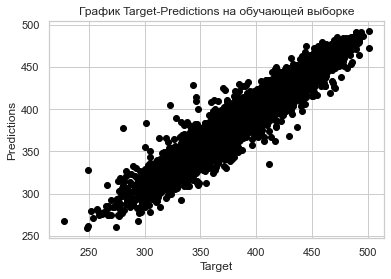

In [64]:
MAE_CB_val_1 = best_model_simulation(model_CB_1, features_val, target_val)

#### Scaled. Масштабированные

Лучшие параметры: {'depth': 10, 'l2_leaf_reg': 9, 'learning_rate': 0.1}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAE модели регрессии на обучающей выборке: 3.7421486973804465
Коэффициент детерминации на обучающей выборке: 0.9807652131649945


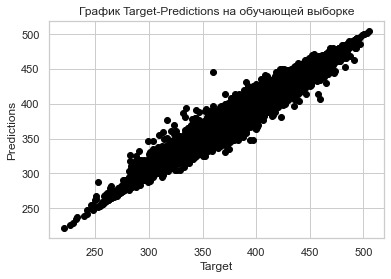

In [65]:
model_CB_2, MAE_CB_train_2 = best_params_CatBoostRegressor(features_train_mapped, target_train)

MAE модели регрессии на обучающей выборке: 9.155198699930587
Коэффициент детерминации на обучающей выборке: 0.9297578017524563


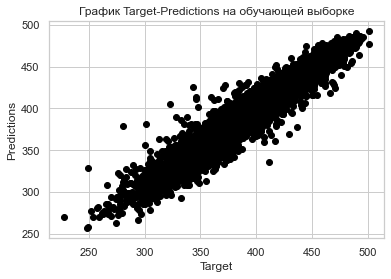

In [66]:
MAE_CB_val_2 = best_model_simulation(model_CB_2, features_val_mapped, target_val)

#### Scaled, important features. Масштабированные, наиболее значимые признаки

Лучшие параметры: {'depth': 10, 'l2_leaf_reg': 3, 'learning_rate': 0.03}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAE модели регрессии на обучающей выборке: 6.654080307780684
Коэффициент детерминации на обучающей выборке: 0.9573685315437358


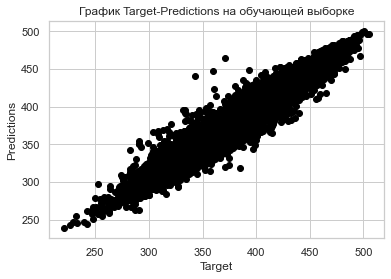

In [67]:
model_CB_3, MAE_CB_train_3 = best_params_CatBoostRegressor(features_train_mapped[features_important], target_train)

MAE модели регрессии на обучающей выборке: 9.07756732058202
Коэффициент детерминации на обучающей выборке: 0.930623359654883


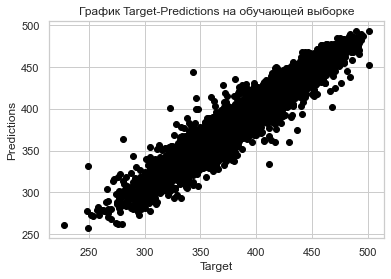

In [68]:
MAE_CB_val_3 = best_model_simulation(model_CB_3, features_val_mapped[features_important], target_val)

#### PCA

Лучшие параметры: {'depth': 10, 'l2_leaf_reg': 9, 'learning_rate': 0.03}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAE модели регрессии на обучающей выборке: 10.26435054751065
Коэффициент детерминации на обучающей выборке: 0.8913391842288442


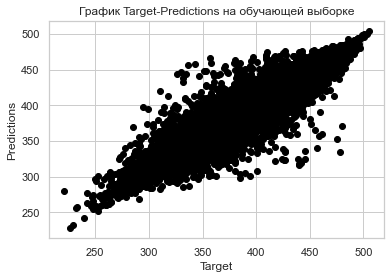

In [69]:
model_CB_4, MAE_CB_train_4 = best_params_CatBoostRegressor(features_train_mapped_pca, target_train)

MAE модели регрессии на обучающей выборке: 12.655745877351059
Коэффициент детерминации на обучающей выборке: 0.8641725406829263


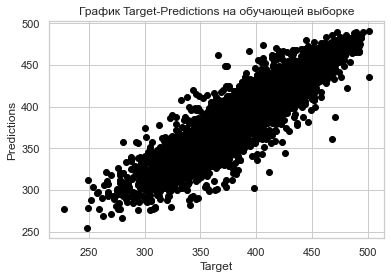

In [70]:
MAE_CB_val_4 = best_model_simulation(model_CB_4, features_val_mapped_pca, target_val)

В данном разделе было выполнено обучение моделей и подбор оптимальных параметров с целью минимизации целевой метрики `MAE`. Использовался `GridSearchCV` для перебора параметров и кросс-валидации. Далее будут приведены таблицы `MAE` на обучающем и валидационном множествах.

## Table with `MAE` for model with optimal parameters. Таблицы `MAE` для моделей с оптимальными параметрами

Index spec:
- 1 - without scaling
- 2 - scaled
- 3 - scaled, important features
- 4 - PCA


- train - train set
- val   - validation set

Значения индексов:
- 1 - без масштабирования
- 2 - масштабированные
- 3 - масштабированные, наиболее значимые признаки
- 4 - PCA


- train - тренировочное множество
- val   - валидационное множество

### Train set. Тренировочное множество

In [71]:
rt_train = pd.DataFrame([['DummyRegressor', MAE_Dummy_train, MAE_Dummy_train, MAE_Dummy_train, MAE_Dummy_train],
                  ['LinearRegression', MAE_LR_train_1, MAE_LR_train_2, MAE_LR_train_3, MAE_LR_train_4],
                  ['RandomForest', MAE_RF_train_1, MAE_RF_train_2, MAE_RF_train_3, MAE_RF_train_4],
                  ['CatBoostRegressor', MAE_CB_train_1, MAE_CB_train_2, MAE_CB_train_3, MAE_CB_train_4]], 
columns=['Model', 'MAE_train_1', 'MAE_train_2', 'MAE_train_3', 'MAE_train_4'])

display(rt_train)

,Model,MAE_train_1,MAE_train_2,MAE_train_3,MAE_train_4
0,DummyRegressor,37.414743,37.414743,37.414743,37.414743
1,LinearRegression,13.327808,12.240415,13.937354,15.291990
2,RandomForest,9.488745,9.486453,9.650762,12.136745
3,CatBoostRegressor,3.761015,3.742149,6.654080,10.264351


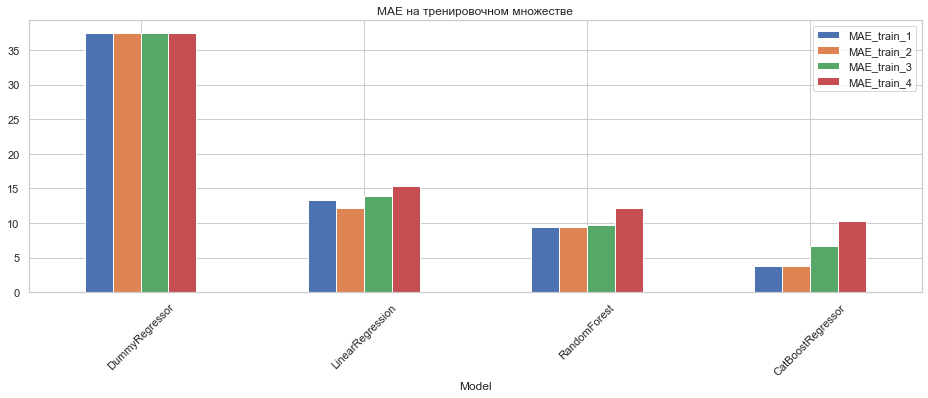

In [72]:
rt_train.plot.bar(x = 'Model', rot = 45, figsize = (16, 5))
plt.title('MAE на тренировочном множестве', fontsize = 12)
plt.legend()
plt.show()

### Validation set. Валидационное множество

In [73]:
rt_val = pd.DataFrame([['DummyRegressor', MAE_Dummy_val, MAE_Dummy_val, MAE_Dummy_val, MAE_Dummy_val],
                  ['LinearRegression', MAE_LR_val_1, MAE_LR_val_2, MAE_LR_val_3, MAE_LR_val_4],
                  ['RandomForest', MAE_RF_val_1, MAE_RF_val_2, MAE_RF_val_3, MAE_RF_val_4],
                  ['CatBoostRegressor', MAE_CB_val_1, MAE_CB_val_2, MAE_CB_val_3, MAE_CB_val_4]], 
columns=['Model', 'MAE_val_1', 'MAE_val_2', 'MAE_val_3', 'MAE_val_4'])

display(rt_val)

,Model,MAE_val_1,MAE_val_2,MAE_val_3,MAE_val_4
0,DummyRegressor,38.172520,38.172520,38.172520,38.172520
1,LinearRegression,13.050815,12.093495,13.633469,15.038360
2,RandomForest,11.280074,11.277132,11.276630,13.573057
3,CatBoostRegressor,9.198155,9.155199,9.077567,12.655746


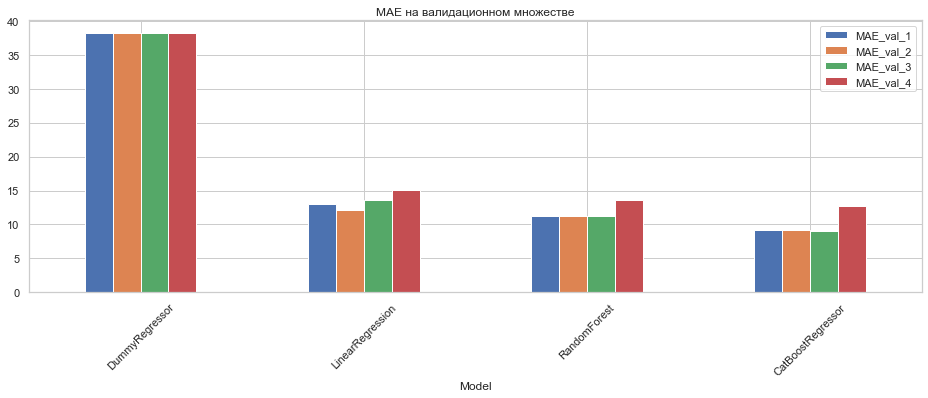

In [74]:
rt_val.plot.bar(x = 'Model', rot = 45, figsize = (16, 5))
plt.title('MAE на валидационном множестве', fontsize = 12)
plt.legend()
plt.show()

The lowest error in training and validation was shown by the `Catboostregressor` model. This model showed the greatest generalizing ability with the most significant features scaled. But if we take into account the results for each model, then the best results were shown: scaled features.

Самую низкую ошибку на обучении и на валидации показала модель `CatBoostRegressor`. Наибольшую обобщающую способность эта модель показала при масштабированных наиболее значимых признаках. Но, если учитывать результаты по каждой модели, то лучшие результаты показали: масштабированные признаки.

## Stacking. Стэкинг

Based on the found optimal parameters of the training models, we will perform stacking. Input data: scaled features.

На основе найденных оптимальных параметров моделей обучения выполним стэкинг. Входные данные: масштабированные признаки.

### Initialization of 1st level models. Инициализация моделей 1-го уровня

In [83]:
models = [
    LinearRegression(),
        
    RandomForestRegressor(random_state = random_state, n_jobs = -1, 
                          n_estimators = 10, max_depth = 9),
        
    CatBoostRegressor(learning_rate = 0.1,
                    depth = 10,
                    l2_leaf_reg = 9,
                    loss_function = 'MAE',
                    silent = True,
                    random_state = random_state)
]

### Training of 1st level models. Обучение моделей 1-го уровня

In [84]:
S_train, S_val = stacking(models,                     # list of models
                        features_train_mapped, np.ravel(target_train), features_val_mapped,   # data
                        regression=True,            # regression task (if you need 
                                                       #     classification - set to False)
                        mode='oof_pred_bag',        # mode: oof for train set, predict test 
                                                       #     set in each fold and find mean
                        save_dir=None,              # do not save result and log (to save 
                                                       #     in current dir - set to '.')
                        metric=mean_absolute_error, # metric: callable
                        n_folds=5,                  # number of folds
                        shuffle=True,               # shuffle the data
                        random_state=0,             # ensure reproducibility
                        verbose=2)                  # print all info

task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    fold  0:  [12.15008628]
    fold  1:  [12.17931357]
    fold  2:  [12.30249942]
    fold  3:  [12.56928200]
    fold  4:  [12.24385758]
    ----
    MEAN:     [12.28900777] + [0.14973724]
    FULL:     [12.28899712]

model  1:     [RandomForestRegressor]
    fold  0:  [11.15220959]
    fold  1:  [11.13375754]
    fold  2:  [11.20954398]
    fold  3:  [11.20612030]
    fold  4:  [11.25382599]
    ----
    MEAN:     [11.19109148] + [0.04312995]
    FULL:     [11.19108736]

model  2:     [CatBoostRegressor]
    fold  0:  [9.30738788]
    fold  1:  [9.15118770]
    fold  2:  [9.19451598]
    fold  3:  [9.39381401]
    fold  4:  [9.28445383]
    ----
    MEAN:     [9.26627188] + [0.08565206]
    FULL:     [9.26626871]



### Initialization and training 2nd level models. Инициализация и обучение модели второго уровня

Лучшие параметры: {'depth': 4, 'l2_leaf_reg': 9, 'learning_rate': 0.03}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAE модели регрессии на обучающей выборке: 8.982818250168
Коэффициент детерминации на обучающей выборке: 0.9267775593579324


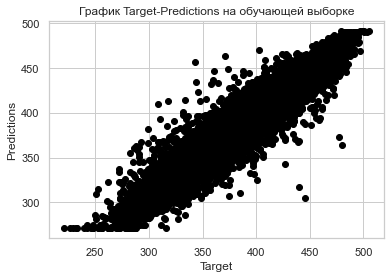

In [85]:
model_CB_stacking, MAE_CB_train_stacking = best_params_CatBoostRegressor(S_train, target_train)

MAE модели регрессии на обучающей выборке: 9.116423256445001
Коэффициент детерминации на обучающей выборке: 0.931065322242521


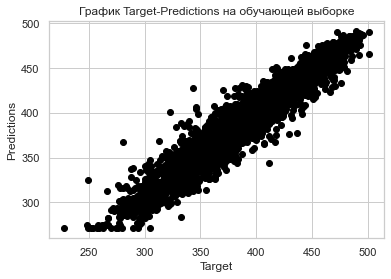

In [86]:
MAE_CB_val_stacking = best_model_simulation(model_CB_stacking, S_val, target_val)

The resulting value of `MAE` did not exceed the best, but the over-fitting of the model decreased. Next, using this construction, we will perform its training on the `train+val` sample and get a forecast on the test sample. Also below is a graph of the significance of input variables for the second-level model.

Полученное значение `MAE` не превзошло наилучшее, но уменьшилась переобученность модели. Далее с помощъю данной конструкции выполним её обучение на выборке `train+val` и получим прогноз на тестовой выборке. Так же внизу выведен график значимости входных переменных для модели второго уровня.

([0, 1, 2], [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

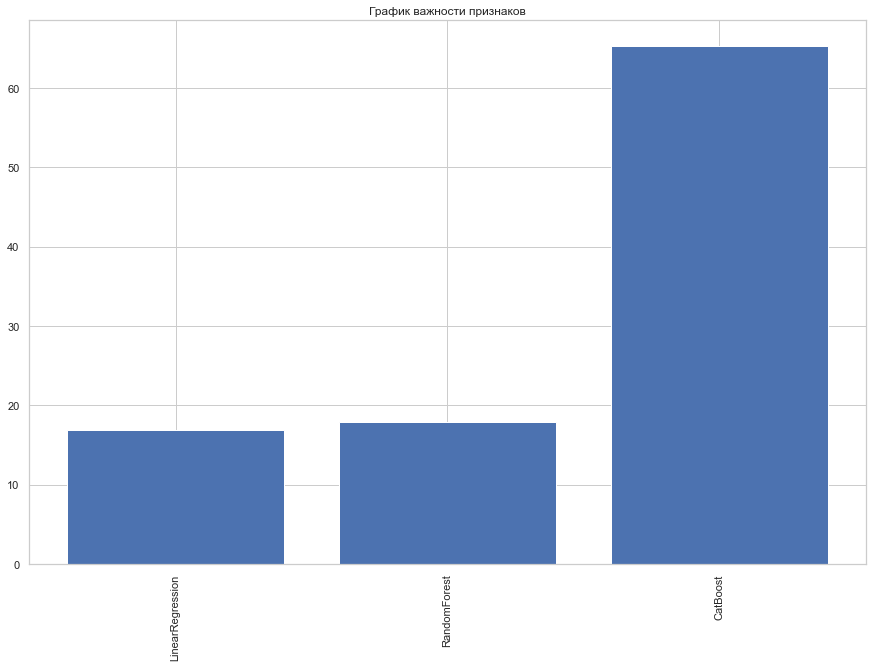

In [87]:
plt.figure(figsize = (15, 10))
plt.title('График важности признаков', fontsize = 12)
plt.bar(['LinearRegression', 'RandomForest', 'CatBoost'], model_CB_stacking.feature_importances_)
plt.xticks(rotation = 90)

This graph clearly shows that the `CatBoostRegressor` model makes the greatest contribution to the forecast, but also not the zero influence of the other two models. Due to the overall contribution, a higher generalizing ability is achieved.

На данном графике хорошо видно, что наибольший вклад в прогноз делает модель `CatBoostRegressor`, но так же не нулевое влияние двух других моделей. За счет общего вклада достигается более высокая обобщающая способность.

### Stacking of 1st level models at `train+val`. Стэкинг моделей 1-го уровня на `train+val`

In [88]:
S_train_val, S_test = stacking(models,                     # list of models
                        features_train_val_mapped, np.ravel(target_train_val), features_test_mapped,   # data
                        regression=True,            # regression task (if you need 
                                                       #     classification - set to False)
                        mode='oof_pred_bag',        # mode: oof for train set, predict test 
                                                       #     set in each fold and find mean
                        save_dir=None,              # do not save result and log (to save 
                                                       #     in current dir - set to '.')
                        metric=mean_absolute_error, # metric: callable
                        n_folds=5,                  # number of folds
                        shuffle=True,               # shuffle the data
                        random_state=0,             # ensure reproducibility
                        verbose=2)                  # print all info

task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    fold  0:  [12.12786457]
    fold  1:  [12.18727960]
    fold  2:  [12.39807031]
    fold  3:  [12.01284922]
    fold  4:  [12.00975666]
    ----
    MEAN:     [12.14716407] + [0.14272837]
    FULL:     [12.14716878]

model  1:     [RandomForestRegressor]
    fold  0:  [11.06327167]
    fold  1:  [11.12631146]
    fold  2:  [11.34590110]
    fold  3:  [11.18469481]
    fold  4:  [10.93114665]
    ----
    MEAN:     [11.13026514] + [0.13683083]
    FULL:     [11.13027196]

model  2:     [CatBoostRegressor]
    fold  0:  [9.20095694]
    fold  1:  [9.11079584]
    fold  2:  [9.17639921]
    fold  3:  [9.07121602]
    fold  4:  [9.03270582]
    ----
    MEAN:     [9.11841477] + [0.06293997]
    FULL:     [9.11841770]



### Training of 2nd level models at `train+val`. Обучение модели 2-го уровня на `train+val`

Лучшие параметры: {'depth': 4, 'l2_leaf_reg': 9, 'learning_rate': 0.03}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAE модели регрессии на обучающей выборке: 8.908150277615274
Коэффициент детерминации на обучающей выборке: 0.9292436277711286


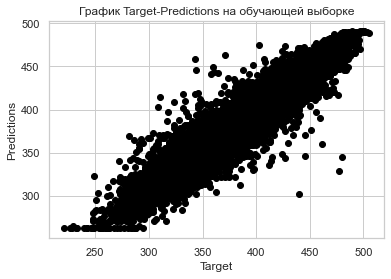

In [89]:
model_CB_train_val_stacking, MAE_CB_train_val_stacking = best_params_CatBoostRegressor(S_train_val, target_train_val)

### Final prediction. Получение итогового прогноза

In [91]:
predictions_final = model_CB_train_val_stacking.predict(S_test)

In [101]:
df_submit = pd.DataFrame(data = predictions_final, index = test_idx, columns = ['quality_predicted'])
display(df_submit.head())
display(df_submit.info())

,quality_predicted
date,
2018-05-04 00:05:00,449.216278
2018-05-04 01:05:00,441.024751
2018-05-04 02:05:00,437.393832
2018-05-04 03:05:00,417.138513
2018-05-04 04:05:00,407.735940


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5808 entries, 2018-05-04 00:05:00 to 2018-12-31 23:05:00
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   quality_predicted  5808 non-null   float64
dtypes: float64(1)
memory usage: 90.8 KB


None

### Export to file. Экспорт прогноза

In [103]:
df_submit.to_csv('F:/Metallurgy/Task2/prediction.csv', index = True, header = False, sep = ';')

## Conclusion. Вывод

In this task, work was done to build a forecast of the quality of the roasting machine. The original data has been uploaded, cleared of abnormal values. Further additional signs were generated. Optimal parameters were selected for machine learning models and their stacking was performed. Retraining on the stacking model is practically absent.

В данном задании была выполнена работа по построению прогноза качества работы машины для обжига. Исходные данные были загружены, очищены от аномальных значений. Далее были сгенерированы дополнительные признаки. Для моделей машинного обучения были выбраны оптимальные параметры и выполнен их стэкинг. Переобученность на модели стэкинга практически отсутствует.